In [109]:
from pathlib import Path
from datetime import datetime
from dateutil import tz

import numpy as np
from datetime import datetime
import xarray as xr
from xarray.backends import NetCDF4DataStore
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from cartopy import crs as ccrs
from metpy.plots import USCOUNTIES
import metpy.calc as mpcalc

## Surface Wind Gusts

In [110]:
%%capture

# Define area to plot
BOTTOM_LAT = 23
TOP_LAT = 40
LEFT_LON = -97
RIGHT_LON = -70

# Model Endpoints 
hrrr = 'https://nomads.ncep.noaa.gov/dods/hrrr/hrrr20210327/hrrr_sfc.t12z'
arw = 'https://nomads.ncep.noaa.gov/dods/hiresw/hiresw20200430/hiresw_conusarw_12z'
nbm = 'https://nomads.ncep.noaa.gov/dods/blend/blend20200417/blend_1hr_22z'
rap = 'https://nomads.ncep.noaa.gov/dods/rap/rap20200722/rap_15z'
gfs = 'https://nomads.ncep.noaa.gov/dods/gfs_0p25/gfs20200429/gfs_0p25_18z'

base_url = hrrr

ds = xr.open_dataset(base_url, decode_times=True)

# Take lat and lon slices
LAT_SLICE = slice(BOTTOM_LAT, TOP_LAT)

if base_url == gfs:
    LON_SLICE = slice(360 + LEFT_LON, 360 + RIGHT_LON)
else:
    LON_SLICE = slice(LEFT_LON, RIGHT_LON)
    
# Extract all lats, lons, and meteorological datasets to plot
lats = ds.lat.sel(lat=LAT_SLICE).values

if base_url == gfs:
    lons = ds.lon.sel(lon=LON_SLICE).values
else:
    lons = 360 + ds.lon.sel(lon=LON_SLICE).values


data = ds.gustsfc

def convert_datetime_from_nomads_to_local(string):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New_York')
    utc_time = datetime.strptime(string, '%Y-%m-%dT%H:%M:%S').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time



## Setup Basemap and Plot Data

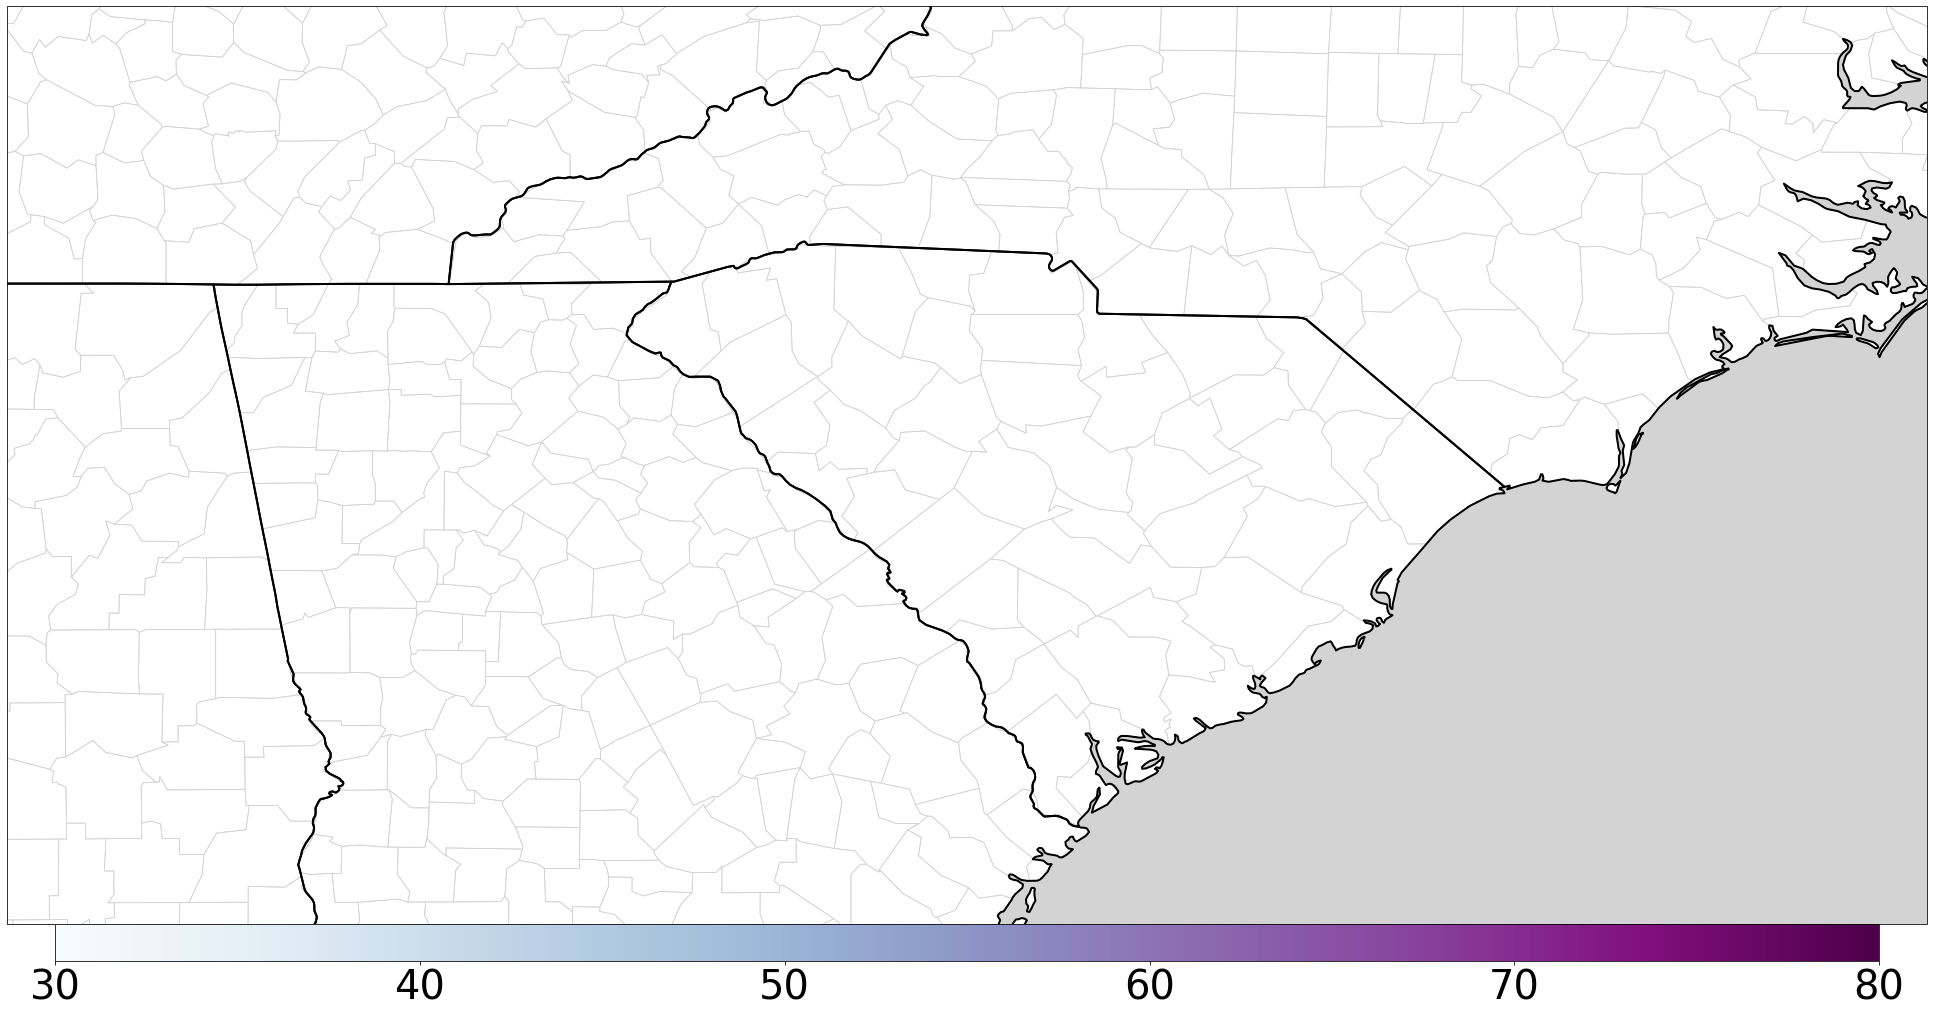

In [111]:
# Setup matplotlib figure
fig = plt.figure(figsize=(1920/72, 1080/72))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

# Add state lines, coastlines, map extent
ax.add_feature(cfeature.OCEAN.with_scale('10m'), color='lightgray')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.75)
ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='lightgray', zorder=1, linewidth=0.75)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=2.00)
#ax.set_extent([-89, -75, 23, 37]) SE CONUS
ax.set_extent([-85, -78, 31.5, 36.5]) #South Carolina
ax.set_adjustable('datalim')

cm = plt.cm.get_cmap('BuPu')
xy = range(90)
z = xy
sc = plt.scatter(xy, xy, c=z, vmin=30, vmax=80, s=35, cmap=cm)
cbar = plt.colorbar(sc, orientation='horizontal', pad=0, aspect=50, shrink=0.95)
cbar.ax.tick_params(labelsize=40)

In [112]:
contour_fills = []

def init():
    global contour_fills
    if len(contour_fills) > 0:
        for contour in contour_fills[0].collections:
            contour.remove()
        contour_fills = []

def plot_model_data(time_step):
    global contour_fills
    
    if len(contour_fills) > 0:
        for contour in contour_fills[0].collections:
            contour.remove()
        contour_fills = []
        
    if len(ax.texts) > 0:
        for txt in ax.texts:
            txt.set_visible(False)
            
    gust = data.isel(time=time_step)
    local_time = convert_datetime_from_nomads_to_local(str(gust.time.values).split('.')[0])
    gust = gust.metpy.sel(lat=LAT_SLICE, lon=LON_SLICE).squeeze().metpy.unit_array
    
    gust_values = np.arange(30, 90, 10)
    contour_fill = ax.contourf(lons, lats, gust * 2.2369362920544, gust_values,
                           cmap=plt.cm.BuPu, transform=ccrs.PlateCarree(), extend='max')
    contour_fills.append(contour_fill)
    
    text = ax.text(0.02, 0.95, s=f'Model Simulated Wind Gusts\n{local_time}',
                   fontsize=72, fontweight='bold', fontname='Arial',
                   color='white', bbox={'facecolor': 'navy', 'alpha': 1.0, 'edgecolor': 'none'},
                   transform=ax.transAxes, zorder=10, va='top')

In [113]:
def animate(frame, start_hour):
    frame += start_hour
    plot_model_data(frame + 1)

In [114]:
plt.rcParams['animation.html'] = 'jshtml'

start_hour = 26
forecast_hours = 9

anim = FuncAnimation(fig, animate, 
                     frames=forecast_hours, 
                     init_func=init, 
                     interval=300, 
                     fargs=(start_hour, ))
anim

In [117]:
graphics_dir = '../..' / Path('.') / 'graphics' / 'models'

#anim.save(f'{graphics_dir}/reflectivity_hrrr.mp4', writer='ffmpeg', fps=3)
anim.save(f'{graphics_dir}/gust_hrrr.gif', writer='pillow', fps=2)